# Correlation of RAI to Eth price moves - Data as of 3-27-2021

We are performing a vector autogression in order to determine if a casual or multi-casual relationship exists between Eth and Rai price moves. This will help use understand system level price dynamics of the Rai system.  

### Vector Autoregression 

Vector autoregression (VAR) is a type of statistical model used to capture the relationship between multiple time series signals as they change over time. VAR models are extensions of univariate autoregression models allowing for multivariate time series analysis.

Autogregressive models use lagged past values of the variable and have an order based on how many times the variable has been lagged, i.e. VAR(2) means two lagged values. Lagged values help to determine if seasonality or reoccuring patterns exist in the data. 

A pth-order VAR model is written as:
$$y_t = c + A_1 y_{t-1} + A_2 y_{t-2} + \cdots + A_p y_{t-p} + e_t,$$

In vector notation, a VAR(1) with 2 variables is:

$$\begin{bmatrix}y_{1,t} \\ y_{2,t}\end{bmatrix} = \begin{bmatrix}c_{1} \\ c_{2}\end{bmatrix} + \begin{bmatrix}a_{1,1}&a_{1,2} \\ a_{2,1}&a_{2,2}\end{bmatrix}\begin{bmatrix}y_{1,t-1} \\ y_{2,t-1}\end{bmatrix} + \begin{bmatrix}e_{1,t} \\ e_{2,t}\end{bmatrix}$$

For our VAR model, we will have a vector of prices, $P$ of EthRai(marketPriceEth), RaiUSD(marketPriceUsd), EthUSD price moves, error between redemptionprice and rai market price, redemptionprice, 15 minuted lated Eth price, total collateral, Uniswap RAI balance relative to totalsupply, max debt ceiling, and collaterlization ratio.

#### Assumptions:
* Every error term has a mean of zero and is normally distributed.
* Variables are stationary. Differencing can be used to make the data stationary.
* Data is on the same scale
* Time sampling is consistent 

### Other methods with fewer assumptions

Non-parametric Bayesian VAR models have been under development and appear to perform well and can operate on nonlinear relationship, heteroscedasticity, and non Gaussian error data[1,2].

Another popular time series analysis modeling technique is the Autorgressive Integrated Moving Average (ARIMA) model. These models are often used in forecasting or when the data shoes evidence of non-stationarity. For multiple time series vectors, like we have here, extensions of the ARIMA model are available, such ARIMAX model that has exogenous variable inputs. ARIMAX models do not have an assumption of Gaussian errors as it uses a maximum likelihood estimation function to fit.

#### References
- 1 Kalli, Maria & Griffin, Jim E., 2018. "Bayesian nonparametric vector autoregressive models," Journal of Econometrics, Elsevier, vol. 203(2), pages 267-282.
- 2 Jeliazkov, Ivan. (2013). Nonparametric Vector Autoregressions: Specification, Estimation, and Inference. Advances in Econometrics. 33. 10.1108/S0731-9053(2013)0000031009. 


We have taken the trade off in assumption for this first version correlation model vs a non-parametric approach for simplicity sake, that current robust python VAR implementations exist, and for illustrative purposes around the concepts we are addressing.


In [381]:
# import libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from math import sqrt


## Data

We import the data obtained in the [TheGraphDataSetCreation](TheGraphDataSetCreation.ipynb) notebook and preprocess it.

In [382]:
graphData = pd.read_csv('saved_results/RaiLiveGraphData.csv')
del graphData['Unnamed: 0']

In [383]:
graphData.head()

,blockNumber,erc20CoinTotalSupply,globalDebt,redemptionPrice,timestamp,hourlyredemptionPriceActual,hourlyredemptionRateActual,hourlymarketPriceEth,hourlymarketPriceUsd,activeLiquidations,...,systemSurplus,totalActiveSafeCount,wethAddress,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,RAIInUniswapV2(RAI/ETH),error,error_integral
0,11857308,1988.440433,1988.577499,"{'block': '11849022', 'id': '0xe313271188492c4...",1613338681,3.14,3.14,0.002589,4.670500,0,...,0.068533,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,661.764843,-1.530500,-1.530500
1,11860793,2788.440433,2788.617717,"{'block': '11860755', 'id': '0x40066774f6fb7d3...",1613384616,3.14,3.14,0.002481,4.377049,0,...,0.108751,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,676.933727,-1.237049,-2.767550
2,11861040,2788.440433,2788.657935,"{'block': '11861008', 'id': '0x0d551e2a2d55fa8...",1613387890,3.14,3.14,0.002481,4.406833,0,...,0.108751,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,676.933727,-1.266833,-4.034383
3,11861337,2788.440433,2788.657935,"{'block': '11861237', 'id': '0x5c67dbb323db039...",1613392101,3.14,3.14,0.002481,4.419266,0,...,0.108751,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,676.933727,-1.279266,-5.313648
4,11861474,3048.440433,3048.645955,"{'block': '11861237', 'id': '0x5c67dbb323db039...",1613394096,3.14,3.14,0.001769,3.194330,0,...,0.116162,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,801.933727,-0.054330,-5.367978


### Exploratory Analysis

In [384]:
graphData.describe()

,blockNumber,erc20CoinTotalSupply,globalDebt,timestamp,hourlyredemptionPriceActual,hourlyredemptionRateActual,hourlymarketPriceEth,hourlymarketPriceUsd,activeLiquidations,debtCeiling,...,debtAvailableToSettle,systemSurplus,totalActiveSafeCount,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,RAIInUniswapV2(RAI/ETH),error,error_integral
count,9.920000e+02,9.920000e+02,9.920000e+02,9.920000e+02,992.000000,992.000000,992.000000,992.000000,992.000000,9.920000e+02,...,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,9.920000e+02,992.000000,992.000000
mean,1.199685e+07,3.439755e+07,3.481814e+07,1.615195e+09,3.060236,3.060236,0.001866,3.182023,0.026210,4.516203e+07,...,285756.928865,113879.589589,815.652218,0.828353,0.999965,0.999719,3.060234,3.004611e+07,-0.121787,-112.503035
std,7.932420e+04,1.346049e+07,1.355960e+07,1.055452e+06,0.047407,0.047407,0.000281,0.421582,0.213846,1.552651e+07,...,362759.598641,67148.009037,263.022771,0.356697,0.000060,0.000480,0.047405,1.260683e+07,0.398726,28.699144
min,1.185731e+07,1.988440e+03,1.988577e+03,1.613339e+09,3.013686,3.013686,0.001600,2.850455,0.000000,1.000000e+07,...,0.000000,-8000.336813,3.000000,0.168066,0.999796,0.998373,3.013686,6.019337e+02,-4.915382,-137.479740
25%,1.192840e+07,3.235290e+07,3.269533e+07,1.614284e+09,3.018353,3.018353,0.001677,2.985101,0.000000,3.996953e+07,...,24653.205369,41310.197532,786.000000,0.523474,0.999926,0.999409,3.018353,2.487122e+07,-0.158660,-134.362636
50%,1.199573e+07,3.637359e+07,3.683013e+07,1.615178e+09,3.031868,3.031868,0.001769,3.093277,0.000000,4.686430e+07,...,45752.103558,146703.219216,858.500000,0.879391,0.999985,0.999883,3.031868,3.144656e+07,-0.046388,-124.303249
75%,1.206429e+07,4.373986e+07,4.442277e+07,1.616092e+09,3.107957,3.107957,0.002026,3.242082,0.000000,5.727986e+07,...,666376.609641,163463.292155,1004.000000,1.125334,1.000013,1.000108,3.107957,3.950621e+07,0.038780,-96.240440
max,1.213630e+07,4.899876e+07,4.918825e+07,1.617050e+09,3.140000,3.140000,0.004474,8.055382,3.000000,5.727986e+07,...,943944.359793,180038.876358,1021.000000,1.562592,1.000051,1.000408,3.140000,4.526917e+07,0.289543,-1.530500


In [385]:
graphData.columns

Index(['blockNumber', 'erc20CoinTotalSupply', 'globalDebt', 'redemptionPrice',
       'timestamp', 'hourlyredemptionPriceActual',
       'hourlyredemptionRateActual', 'hourlymarketPriceEth',
       'hourlymarketPriceUsd', 'activeLiquidations', 'currentFsmUpdate',
       'currentMedianizerUpdate', 'debtCeiling', 'liquidationsStarted',
       'totalAnnualizedStabilityFee', 'totalCollateral', 'Eth_price',
       'coinAddress', 'coinUniswapPair', 'currentCoinMedianizerUpdate',
       'debtAvailableToSettle', 'globalDebtCeiling', 'systemSurplus',
       'totalActiveSafeCount', 'wethAddress', 'RedemptionRateAnnualizedRate',
       'RedemptionRateHourlyRate', 'RedemptionRateEightHourlyRate',
       'RedemptionPrice', 'RAIInUniswapV2(RAI/ETH)', 'error',
       'error_integral'],
      dtype='object')

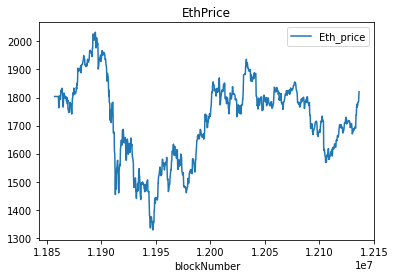

In [386]:
graphData.plot(x='blockNumber',y='Eth_price',kind='line',title='EthPrice')

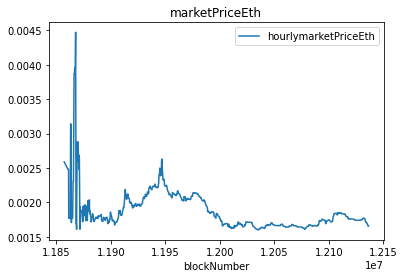

In [387]:
graphData.plot(x='blockNumber',y='hourlymarketPriceEth',kind='line',title='marketPriceEth')

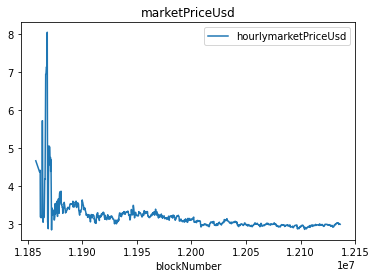

In [388]:
graphData.plot(x='blockNumber',y='hourlymarketPriceUsd',kind='line',title='marketPriceUsd')

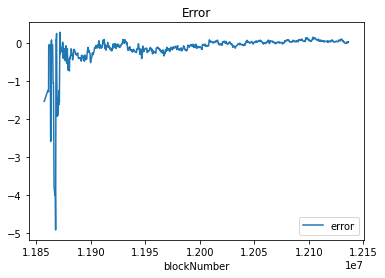

In [389]:
graphData.plot(x='blockNumber',y='error',kind='line',title='Error')

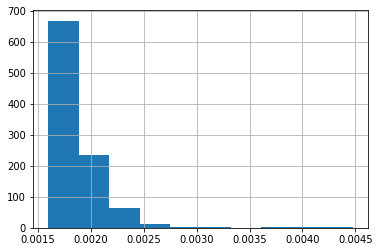

In [390]:
graphData.hourlymarketPriceEth.hist()

Due to the large spikes the market prices during the system initialization, we will cut out the first 100 observations.

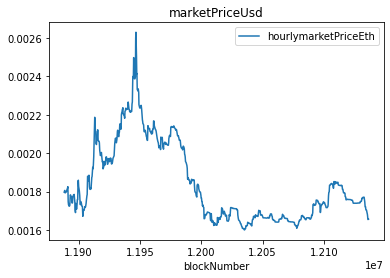

In [391]:
graphData[100:].plot(x='blockNumber',y='hourlymarketPriceEth',kind='line',title='marketPriceUsd')

## New features Creation
Based on discussions with the Rai team, we will add the following signls to the VAR model:
* ### New variables to add (with calculations - references from Graph Data):
    * Error = hourlyredemptionPriceActual - hourlymarketPriceUsd
    * Redemption rate = hourlyredemptionPriceActual
    * Uniswap RAI balance relative to total RAI supply = systemState.coinUniswapPair.apply(lambda x: x['reserve0'])/globalDebt
    * Rai supply/Rai cap (max debt ceiling) =  globalDebt/debtCeiling
    * ETH locked in collateral = totalCollateral
    * Collateralization ratio = (totalCollateral * hourlymarketPriceEth)/(globalDebt * hourlymarketPriceEth)
    * Add lagged Eth value (15 mins) - See below
    
### 15 min lagged Eth

In [392]:
# since difference is nan on first value, seed list with initial market price
laggedEthValue = [graphData['hourlymarketPriceEth'][0]]
graphData['timestampDiff'] = graphData.timestamp.diff()
#15 mins
seconds = 60 * 15
lastRowDiff = 0


for i, row in graphData.iterrows():
    if i > 0:
        lastRowIndex = i-1
        if row['timestampDiff'] >= seconds:
            laggedEthValue.append(graphData['hourlymarketPriceEth'][lastRowIndex])
        else:
            lastRowIndex = i-2
            print("Using last Eth value because diff wasn't block occured before 15 mins had passed")
            print(lastRowIndex)
            laggedEthValue.append(graphData['hourlymarketPriceEth'][lastRowIndex])
        lastRowDiff = row['timestampDiff']
    else:
        pass
    
graphData['15MinLaggedmarketPriceEth'] = laggedEthValue

Using last Eth value because diff wasn't block occured before 15 mins had passed
371
Using last Eth value because diff wasn't block occured before 15 mins had passed
565
Using last Eth value because diff wasn't block occured before 15 mins had passed
600
Using last Eth value because diff wasn't block occured before 15 mins had passed
631
Using last Eth value because diff wasn't block occured before 15 mins had passed
792
Using last Eth value because diff wasn't block occured before 15 mins had passed
871
Using last Eth value because diff wasn't block occured before 15 mins had passed
907
Using last Eth value because diff wasn't block occured before 15 mins had passed
931


In [393]:
# create features
graphData['error'] = graphData['hourlyredemptionPriceActual'] - graphData['hourlymarketPriceUsd']
graphData['UniswapRAIBalanceRelativeToTotalSupply'] =  graphData['RAIInUniswapV2(RAI/ETH)'] / graphData['globalDebt']
graphData['MaxDebtCeiling'] = graphData['globalDebt'] / graphData['debtCeiling']
graphData['CollateralizationRatio'] =  (graphData['totalCollateral'] * graphData['hourlymarketPriceEth']) / (graphData['globalDebt'] * graphData['hourlymarketPriceEth'])

In [394]:
# subset data to vector for VAR
P = graphData[100:][['error','hourlyredemptionPriceActual','hourlymarketPriceEth','hourlymarketPriceUsd',
                     'Eth_price','15MinLaggedmarketPriceEth','totalCollateral',
                     'UniswapRAIBalanceRelativeToTotalSupply','MaxDebtCeiling',
                     'CollateralizationRatio']]

In [395]:
P.describe()

,error,hourlyredemptionPriceActual,hourlymarketPriceEth,hourlymarketPriceUsd,Eth_price,15MinLaggedmarketPriceEth,totalCollateral,UniswapRAIBalanceRelativeToTotalSupply,MaxDebtCeiling,CollateralizationRatio
count,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000
mean,-0.056700,3.051361,0.001841,3.108061,1703.638594,0.001841,174553.287850,0.856512,0.781910,0.004547
std,0.123631,0.041440,0.000203,0.154350,146.677731,0.000203,39577.970295,0.053847,0.054233,0.000377
min,-0.510456,3.013686,0.001600,2.864213,1328.192602,0.001600,41235.497030,0.677439,0.674183,0.003637
25%,-0.136891,3.018053,0.001673,2.979885,1588.641108,0.001673,170822.002674,0.835609,0.735793,0.004285
50%,-0.030693,3.029881,0.001757,3.064420,1715.989760,0.001757,189023.071883,0.860486,0.773782,0.004568
75%,0.042622,3.091625,0.002023,3.216821,1808.172737,0.002023,196835.923450,0.898156,0.834218,0.004890
max,0.160603,3.135706,0.002631,3.639484,2032.578356,0.002631,209393.009759,0.922497,1.000348,0.005530


## Time Analysis

Question: Are we sampling more often then the control period or is the controller not activated everytime it could be because the error is not large enough?

* What type of samplimg time do we have? 

To answer these questions, we will calculate the timestamp difference and create a histogram of the time differences and determine if we have equal time sampling or not.

In [396]:
# convert timestamps to human readable
graphData['timestamp_human'] = pd.to_datetime(graphData['timestamp'],origin='unix',unit='s')

In [397]:
graphData['timestampDiff'] = graphData.timestamp.diff()

In [398]:
graphData.timestampDiff.describe()

count      991.000000
mean      3744.791120
std       1766.328015
min        430.000000
25%       3099.000000
50%       3694.000000
75%       4205.500000
max      45935.000000
Name: timestampDiff, dtype: float64

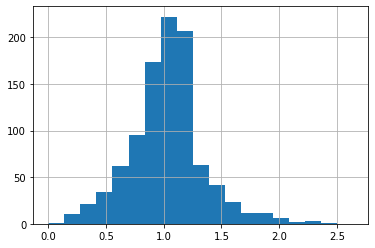

In [399]:
graphData.timestampDiff.apply(lambda x: x/3600).hist(bins=np.arange(0,10000/3600,500/3600))

**Conclusion**: Based on the histogram above, we can see that the timestamp differences are approximately normally distributed around every hour. Thus our sampling periods are uneven and we need to explore potential adjustments to the VAR model to account for the uneven distributions in time. Time series analysis of uneven sample periods is rather limited in the literature, with three dominant methods emerging: "Hope and Pray", interpolation, and state based models, which are complex to configure and beyond the scope of this analysis. For our next steps, we will create a dataset resampled to every 60 mins and linearly interpolate our data when necessary. We will then run our results twice, once with the "Hope and Pray" method and once with the interpolated data.

In [400]:
# basic interpolation
resampled = graphData.resample('60min', on='timestamp_human').mean()
interpolated = resampled.interpolate(method='linear')
interpolated.head()

,blockNumber,erc20CoinTotalSupply,globalDebt,timestamp,hourlyredemptionPriceActual,hourlyredemptionRateActual,hourlymarketPriceEth,hourlymarketPriceUsd,activeLiquidations,debtCeiling,...,RedemptionRateEightHourlyRate,RedemptionPrice,RAIInUniswapV2(RAI/ETH),error,error_integral,timestampDiff,15MinLaggedmarketPriceEth,UniswapRAIBalanceRelativeToTotalSupply,MaxDebtCeiling,CollateralizationRatio
timestamp_human,,,,,,,,,,,,,,,,,,,,,
2021-02-14 21:00:00,1.185731e+07,1988.440433,1988.577499,1.613339e+09,3.14,3.14,0.002589,4.670500,0.0,10000000.0,...,1.0,3.14,661.764843,-1.530500,-1.530500,NaN,0.002589,0.332783,0.000199,0.007489
2021-02-14 22:00:00,1.185758e+07,2049.978895,2050.119055,1.613342e+09,3.14,3.14,0.002581,4.647927,0.0,10000000.0,...,1.0,3.14,662.931680,-1.507927,-1.625658,NaN,0.002589,0.325857,0.000205,0.007324
2021-02-14 23:00:00,1.185784e+07,2111.517356,2111.660610,1.613346e+09,3.14,3.14,0.002573,4.625354,0.0,10000000.0,...,1.0,3.14,664.098517,-1.485354,-1.720815,NaN,0.002589,0.318932,0.000211,0.007158
2021-02-15 00:00:00,1.185811e+07,2173.055818,2173.202165,1.613349e+09,3.14,3.14,0.002565,4.602781,0.0,10000000.0,...,1.0,3.14,665.265354,-1.462781,-1.815973,NaN,0.002589,0.312006,0.000217,0.006993
2021-02-15 01:00:00,1.185838e+07,2234.594279,2234.743720,1.613353e+09,3.14,3.14,0.002556,4.580208,0.0,10000000.0,...,1.0,3.14,666.432192,-1.440208,-1.911131,NaN,0.002589,0.305080,0.000223,0.006828


In [401]:
interpolated.tail()

,blockNumber,erc20CoinTotalSupply,globalDebt,timestamp,hourlyredemptionPriceActual,hourlyredemptionRateActual,hourlymarketPriceEth,hourlymarketPriceUsd,activeLiquidations,debtCeiling,...,RedemptionRateEightHourlyRate,RedemptionPrice,RAIInUniswapV2(RAI/ETH),error,error_integral,timestampDiff,15MinLaggedmarketPriceEth,UniswapRAIBalanceRelativeToTotalSupply,MaxDebtCeiling,CollateralizationRatio
timestamp_human,,,,,,,,,,,,,,,,,,,,,
2021-03-29 16:00:00,12135201.0,4.063027e+07,4.088030e+07,1.617035e+09,3.033508,3.033508,0.001690,3.018304,0.0,5.727986e+07,...,1.000075,3.033508,3.594859e+07,0.015204,-120.924481,3253.0,0.001694,0.879362,0.713694,0.004640
2021-03-29 17:00:00,12135416.0,4.057271e+07,4.082221e+07,1.617038e+09,3.033508,3.033508,0.001679,3.000110,0.0,5.727986e+07,...,1.000075,3.033508,3.597762e+07,0.033397,-120.891084,2936.0,0.001690,0.881325,0.712680,0.004638
2021-03-29 18:00:00,12135813.0,3.999456e+07,4.024393e+07,1.617043e+09,3.033569,3.033569,0.001654,3.011698,0.0,5.727986e+07,...,1.000003,3.033569,3.552787e+07,0.021871,-120.869212,5211.0,0.001679,0.882813,0.702584,0.004629
2021-03-29 19:00:00,12135917.0,3.997254e+07,4.022217e+07,1.617045e+09,3.033569,3.033569,0.001654,3.011661,0.0,5.727986e+07,...,1.000003,3.033569,3.552809e+07,0.021908,-120.847304,1451.0,0.001654,0.883296,0.702204,0.004629
2021-03-29 20:00:00,12136305.0,3.996654e+07,4.021624e+07,1.617050e+09,3.033571,3.033571,0.001656,2.998933,0.0,5.727986e+07,...,1.000003,3.033571,3.550407e+07,0.034638,-120.812666,5238.0,0.001654,0.882829,0.702101,0.004628


In [402]:
# subset data to vector for VAR
interpolated.reset_index(inplace=True)
P_interpolated = interpolated[100:][['error','hourlyredemptionPriceActual','hourlymarketPriceEth','hourlymarketPriceUsd',
                     'Eth_price','15MinLaggedmarketPriceEth','totalCollateral',
                     'UniswapRAIBalanceRelativeToTotalSupply','MaxDebtCeiling',
                     'CollateralizationRatio']]

In [403]:
P_interpolated.head()

,error,hourlyredemptionPriceActual,hourlymarketPriceEth,hourlymarketPriceUsd,Eth_price,15MinLaggedmarketPriceEth,totalCollateral,UniswapRAIBalanceRelativeToTotalSupply,MaxDebtCeiling,CollateralizationRatio
100,-0.262469,3.137853,0.001755,3.400321,1937.022792,0.001787,32023.481456,0.747451,0.780487,0.003831
101,-0.160782,3.137659,0.001722,3.298441,1937.022792,0.001755,32485.731456,0.747159,0.795475,0.003813
102,-0.175424,3.137454,0.001729,3.312878,1937.063089,0.001722,34643.912456,0.766599,0.739151,0.003733
103,-0.174712,3.137307,0.001728,3.312019,1915.874153,0.001729,36047.683456,0.777671,0.770138,0.003728
104,-0.208733,3.137144,0.001748,3.345877,1916.732672,0.001728,36902.030456,0.779820,0.781020,0.003763


### Data Transformations

We will take the log of the data to reduce the skewness and take the first difference to make the data stationary, meaning that the distribution does not change when shifted by tie.

In [404]:
## Difference and log values
for i in P.columns:
    P[i +'_log_differenced'] = np.log(P[i]).diff()
    
# for interpolated data
for i in P_interpolated.columns:
    P_interpolated[i +'_log_differenced'] = np.log(P_interpolated[i]).diff()

/home/aclarkdata/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


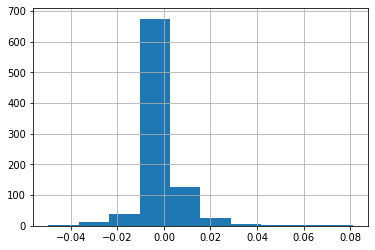

In [405]:
P.hourlymarketPriceEth_log_differenced.hist()

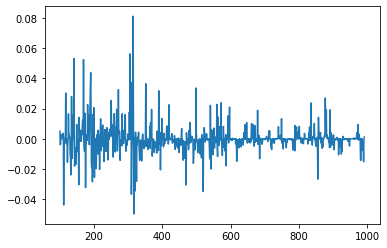

In [406]:
P.hourlymarketPriceEth_log_differenced.plot()

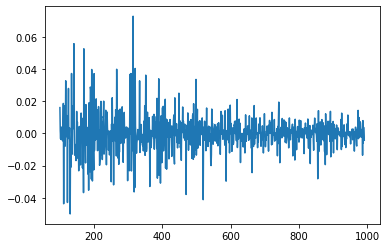

In [407]:
P.hourlymarketPriceUsd_log_differenced.plot()

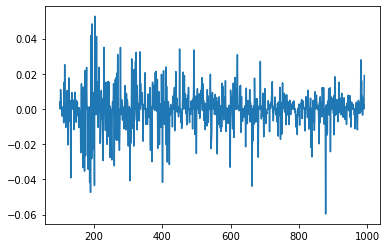

In [408]:
P.Eth_price_log_differenced.plot()

In [409]:
P.describe()

,error,hourlyredemptionPriceActual,hourlymarketPriceEth,hourlymarketPriceUsd,Eth_price,15MinLaggedmarketPriceEth,totalCollateral,UniswapRAIBalanceRelativeToTotalSupply,MaxDebtCeiling,CollateralizationRatio,error_log_differenced,hourlyredemptionPriceActual_log_differenced,hourlymarketPriceEth_log_differenced,hourlymarketPriceUsd_log_differenced,Eth_price_log_differenced,15MinLaggedmarketPriceEth_log_differenced,totalCollateral_log_differenced,UniswapRAIBalanceRelativeToTotalSupply_log_differenced,MaxDebtCeiling_log_differenced,CollateralizationRatio_log_differenced
count,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,362.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,-0.056700,3.051361,0.001841,3.108061,1703.638594,0.001841,174553.287850,0.856512,0.781910,0.004547,0.008172,-0.000037,-0.000092,-0.000165,-0.000063,-0.000072,0.001691,0.000091,-0.000106,0.000245
std,0.123631,0.041440,0.000203,0.154350,146.677731,0.000203,39577.970295,0.053847,0.054233,0.000377,0.598934,0.000079,0.009033,0.010987,0.010895,0.009055,0.013736,0.010256,0.017999,0.009318
min,-0.510456,3.013686,0.001600,2.864213,1328.192602,0.001600,41235.497030,0.677439,0.674183,0.003637,-2.298105,-0.000402,-0.049693,-0.050115,-0.059595,-0.049693,-0.103865,-0.081128,-0.198478,-0.095230
25%,-0.136891,3.018053,0.001673,2.979885,1588.641108,0.001673,170822.002674,0.835609,0.735793,0.004285,-0.188553,-0.000074,-0.002363,-0.004194,-0.002576,-0.002363,-0.000214,-0.000664,-0.000450,-0.000546
50%,-0.030693,3.029881,0.001757,3.064420,1715.989760,0.001757,189023.071883,0.860486,0.773782,0.004568,0.000000,0.000000,-0.000051,0.000000,0.000000,-0.000051,0.000026,0.000033,0.000023,0.000000
75%,0.042622,3.091625,0.002023,3.216821,1808.172737,0.002023,196835.923450,0.898156,0.834218,0.004890,0.184321,0.000013,0.000779,0.004093,0.003933,0.000751,0.001181,0.001199,0.001431,0.000575
max,0.160603,3.135706,0.002631,3.639484,2032.578356,0.002631,209393.009759,0.922497,1.000348,0.005530,5.265167,0.000105,0.081117,0.072969,0.052679,0.081117,0.133431,0.093861,0.115056,0.109671


In [410]:
P = P[['error_log_differenced','hourlyredemptionPriceActual_log_differenced','hourlymarketPriceEth_log_differenced','hourlymarketPriceUsd_log_differenced', 
       'Eth_price_log_differenced','15MinLaggedmarketPriceEth_log_differenced',
       'totalCollateral_log_differenced',
       'UniswapRAIBalanceRelativeToTotalSupply_log_differenced',
       'MaxDebtCeiling_log_differenced',
       'CollateralizationRatio_log_differenced']]


P_interpolated = P_interpolated[['error_log_differenced','hourlyredemptionPriceActual_log_differenced','hourlymarketPriceEth_log_differenced','hourlymarketPriceUsd_log_differenced', 
       'Eth_price_log_differenced','15MinLaggedmarketPriceEth_log_differenced',
       'totalCollateral_log_differenced',
       'UniswapRAIBalanceRelativeToTotalSupply_log_differenced',
       'MaxDebtCeiling_log_differenced',
       'CollateralizationRatio_log_differenced']]


Standardize the data (rescale values to mean of a 0 and a standard deviation of 1). Standardization will move these different scales/order of magnitude to the same. 

In [411]:
# scaler objects
scalers = []
for i in P.columns:
    # train the standardization
    scaler = StandardScaler()
    # prepare data for standardization
    values = P[i].values
    values = values.reshape((len(values), 1))
    scaler = scaler.fit(values)
    print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
    scalers.append(scaler)
    string = i + '_standardized'
    P[string] = scaler.transform(values)
    
scalers_interpolated = []
for i in P_interpolated.columns:
    # train the standardization
    scaler = StandardScaler()
    # prepare data for standardization
    values = P_interpolated[i].values
    values = values.reshape((len(values), 1))
    scaler = scaler.fit(values)
    print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
    scalers_interpolated.append(scaler)
    string = i + '_standardized'
    P_interpolated[string] = scaler.transform(values)

Mean: 0.008172, StandardDeviation: 0.598106
Mean: -0.000037, StandardDeviation: 0.000079
Mean: -0.000092, StandardDeviation: 0.009028
Mean: -0.000165, StandardDeviation: 0.010981
Mean: -0.000063, StandardDeviation: 0.010889
Mean: -0.000072, StandardDeviation: 0.009050
Mean: 0.001691, StandardDeviation: 0.013728
Mean: 0.000091, StandardDeviation: 0.010250
Mean: -0.000106, StandardDeviation: 0.017989
Mean: 0.000245, StandardDeviation: 0.009313
Mean: 0.005510, StandardDeviation: 0.568048
Mean: -0.000036, StandardDeviation: 0.000077
Mean: -0.000063, StandardDeviation: 0.008845
Mean: -0.000135, StandardDeviation: 0.010801
Mean: -0.000067, StandardDeviation: 0.010629
Mean: -0.000083, StandardDeviation: 0.008896
Mean: 0.001890, StandardDeviation: 0.013699
Mean: 0.000179, StandardDeviation: 0.010102
Mean: -0.000114, StandardDeviation: 0.018325
Mean: 0.000203, StandardDeviation: 0.009123


The following code can be used to inverse the transform
```
inversed = scaler.inverse_transform(normalized)
```

In [412]:
P = P[['error_log_differenced_standardized','hourlyredemptionPriceActual_log_differenced_standardized',
       'hourlymarketPriceEth_log_differenced_standardized','hourlymarketPriceUsd_log_differenced_standardized', 
       'Eth_price_log_differenced_standardized','15MinLaggedmarketPriceEth_log_differenced_standardized',
       'totalCollateral_log_differenced_standardized',
       'UniswapRAIBalanceRelativeToTotalSupply_log_differenced_standardized',
       'MaxDebtCeiling_log_differenced_standardized',
       'CollateralizationRatio_log_differenced_standardized']]


P_interpolated = P_interpolated[['error_log_differenced_standardized','hourlyredemptionPriceActual_log_differenced_standardized',
       'hourlymarketPriceEth_log_differenced_standardized','hourlymarketPriceUsd_log_differenced_standardized', 
       'Eth_price_log_differenced_standardized','15MinLaggedmarketPriceEth_log_differenced_standardized',
       'totalCollateral_log_differenced_standardized',
       'UniswapRAIBalanceRelativeToTotalSupply_log_differenced_standardized',
       'MaxDebtCeiling_log_differenced_standardized',
       'CollateralizationRatio_log_differenced_standardized']]

In [413]:
P.describe()

,error_log_differenced_standardized,hourlyredemptionPriceActual_log_differenced_standardized,hourlymarketPriceEth_log_differenced_standardized,hourlymarketPriceUsd_log_differenced_standardized,Eth_price_log_differenced_standardized,15MinLaggedmarketPriceEth_log_differenced_standardized,totalCollateral_log_differenced_standardized,UniswapRAIBalanceRelativeToTotalSupply_log_differenced_standardized,MaxDebtCeiling_log_differenced_standardized,CollateralizationRatio_log_differenced_standardized
count,3.620000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02
mean,-2.146840e-18,-1.060319e-15,-3.551218e-17,4.610354e-18,-4.012254e-17,-2.528101e-17,-4.675771e-17,4.018484e-18,-3.198336e-18,-2.815275e-17
std,1.001384e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00
min,-3.855965e+00,-4.627054e+00,-5.493981e+00,-4.548671e+00,-5.467393e+00,-5.482821e+00,-7.689208e+00,-7.923717e+00,-1.102731e+01,-1.025201e+01
25%,-3.289132e-01,-4.630885e-01,-2.516403e-01,-3.668589e-01,-2.308143e-01,-2.531568e-01,-1.388083e-01,-7.372027e-02,-1.912213e-02,-8.498337e-02
50%,-1.366349e-02,4.708026e-01,4.508585e-03,1.504038e-02,5.805121e-03,2.372703e-03,-1.213083e-01,-5.675350e-03,7.156250e-03,-2.632443e-02
75%,2.945115e-01,6.410150e-01,9.638429e-02,3.877283e-01,3.670529e-01,9.095198e-02,-3.716769e-02,1.081220e-01,8.542054e-02,3.542098e-02
max,8.789396e+00,1.796633e+00,8.994805e+00,6.659908e+00,4.843796e+00,8.970930e+00,9.596536e+00,9.148118e+00,6.401760e+00,1.174994e+01


In [414]:
P.dropna(inplace=True)
P_interpolated.dropna(inplace=True)

As a final check prior to modeling, we will run the Augmented Dickey-Fuller test to ensure that our data is stationary (non-unit root - A unit root is a stochastic trend in a time series). The test's hypothesis are:


* $H_O: \textrm{Time series has a unit root}$
* $H_A: \textrm{Time series does not have a unit root}$

In [415]:
for i in P.columns:
    print(i)
    result = adfuller(P[i].values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        decision = "fail to reject - unit root present"
    else:
        decision = "reject, no unit root present"
    print(decision)
    print('----------------------------------')

print('----------------------------------')
print('Interpolated:')
print('----------------------------------')
for i in P_interpolated.columns:
    print(i)
    result = adfuller(P_interpolated[i].values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        decision = "fail to reject - unit root present"
    else:
        decision = "reject, no unit root present"
    print(decision)
    print('----------------------------------')

error_log_differenced_standardized
ADF Statistic: -11.977079
p-value: 0.000000
reject, no unit root present
----------------------------------
hourlyredemptionPriceActual_log_differenced_standardized
ADF Statistic: -4.687428
p-value: 0.000089
reject, no unit root present
----------------------------------
hourlymarketPriceEth_log_differenced_standardized
ADF Statistic: -7.487454
p-value: 0.000000
reject, no unit root present
----------------------------------
hourlymarketPriceUsd_log_differenced_standardized
ADF Statistic: -11.276230
p-value: 0.000000
reject, no unit root present
----------------------------------
Eth_price_log_differenced_standardized
ADF Statistic: -11.843790
p-value: 0.000000
reject, no unit root present
----------------------------------
15MinLaggedmarketPriceEth_log_differenced_standardized
ADF Statistic: -8.634531
p-value: 0.000000
reject, no unit root present
----------------------------------
totalCollateral_log_differenced_standardized
ADF Statistic: -2.838962

Based on the Augmented Dickey-Fuller, our preprocessing was successful and none of our univariate time series signals as a unit root. We can now proceed to the VAR model.

## Fit model

In [416]:
# instantiate the var model object from statsmodels
model = VAR(P)
model_interpolated = VAR(P_interpolated)

/home/aclarkdata/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/aclarkdata/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [417]:
# calculate the best autocorrelation value
results = model.fit(maxlags=15, ic='aic')
results_interpolated = model_interpolated.fit(maxlags=15, ic='aic')

In [418]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 31, Mar, 2021
Time:                     14:58:28
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -3.93008
Nobs:                     347.000    HQIC:                  -14.0113
Log likelihood:           174.392    FPE:                1.94295e-09
AIC:                     -20.6807    Det(Omega_mle):     5.24159e-11
--------------------------------------------------------------------
Results for equation error_log_differenced_standardized
                                                                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------------------------------------------------
const                                                                        

In [419]:
results_interpolated.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 31, Mar, 2021
Time:                     14:58:30
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -5.38116
Nobs:                     370.000    HQIC:                  -15.0085
Log likelihood:           210.136    FPE:                8.82856e-10
AIC:                     -21.3525    Det(Omega_mle):     2.88091e-11
--------------------------------------------------------------------
Results for equation error_log_differenced_standardized
                                                                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------------------------------------------------
const                                                                        

The Akaike information criterion(AIC) is used to evaluate how well a model fits the data. It penalizes for more independent variables to try to prevent over-fitting. AIC is calculated by the maximum log-likelihood of the model and the number of parameters (K) used to reach that likelihood. The AIC function is 2K – 2(log-likelihood).

Lower AIC values indicate a better-fit model, and a model with a delta-AIC (the difference between the two AIC values being compared) of more than -2 is considered significantly better than the model it is being compared to.

- https://www.scribbr.com/statistics/akaike-information-criterion/

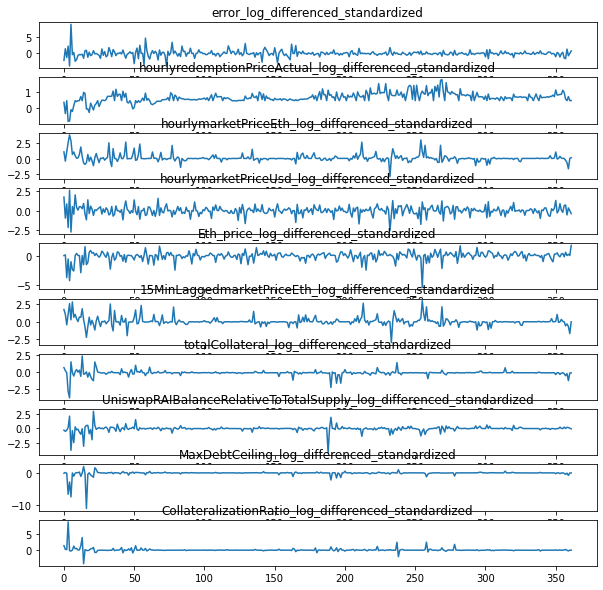

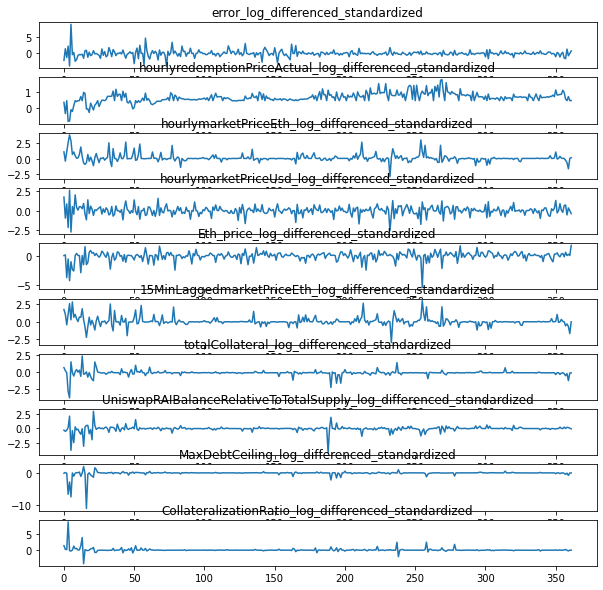

In [420]:
results.plot()

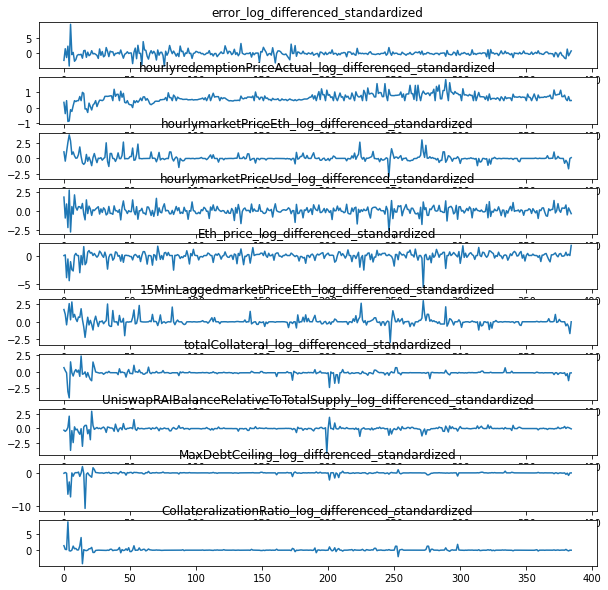

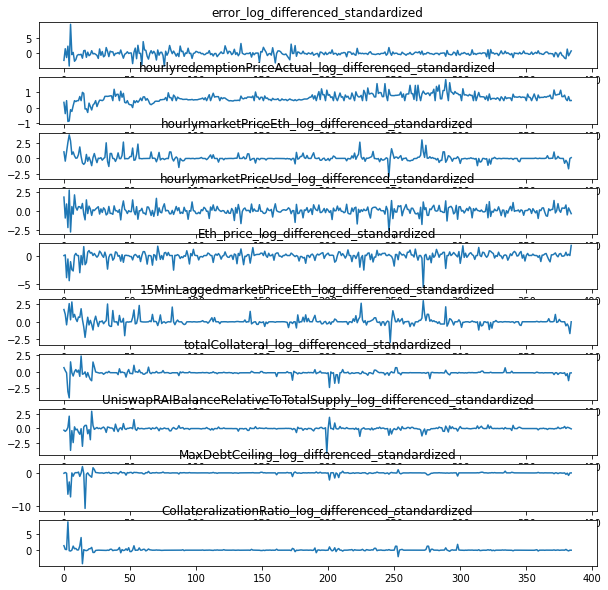

In [421]:
results_interpolated.plot()

## Granger causality

Granger causality is a hypothesis test for determining whether one time series is useful in forecasting another. We can say that a variable X, or variables, evolves over time Granger-causes another evolving variable Y if predictions of the value of Y based on its own past values and on the past values of X are better than predictions of Y based only on Y's own past values.


In our analysis, we present the hypothesis that Eth is a driver of Rai market price. In statistical parlance, we have the following:

* $H_O: \textrm{Eth price does not Granger cause Rai market price}$
* $H_A: \textrm{Eth price does Granger cause Rai market price}$

We will perform now perform the Granger Causality hypothesis test with an $\alpha = 0.05$ value using an F test to determine if the eth price has any casual component for predicting the Rai market price. If the p-value (the probability of obtaining test results at least as extreme as the results actually observed) of the test is less than or equal to $\alpha$ we will reject the null hypothesis and determine that Eth price is a driver of Rai market price.

In [422]:
results.test_causality(['hourlymarketPriceEth_log_differenced_standardized', 
                        'hourlymarketPriceUsd_log_differenced_standardized'],
                       'Eth_price_log_differenced_standardized', kind='f',signif=0.05).summary()

Test statistic,Critical value,p-value,df
1.579,1.465,0.024,"(30, 1960)"


Based on the Granger Causality test, we reject $H_O$ which means that Eth price does have a causal influence on Rai price.

In [423]:
results.test_causality('hourlymarketPriceEth_log_differenced_standardized',
                       'Eth_price_log_differenced_standardized', kind='f',signif=0.05).summary()

Test statistic,Critical value,p-value,df
2.591,1.671,0.001,"(15, 1960)"


Based on the Granger Causality test, we reject $H_O$ which means that Eth price does have a causal influence on Rai price in Eth.

In [424]:
results.test_causality('hourlymarketPriceUsd_log_differenced_standardized',
                       'Eth_price_log_differenced_standardized', kind='f',signif=0.05).summary()

Test statistic,Critical value,p-value,df
0.5494,1.671,0.913,"(15, 1960)"


Based on the Granger Causality test, we reject $H_O$ which means that Eth price does have a causal influence on Rai price in Usd.

In [425]:
results.test_causality('hourlymarketPriceEth_log_differenced_standardized',
                       '15MinLaggedmarketPriceEth_log_differenced_standardized', kind='f',signif=0.05).summary()

Test statistic,Critical value,p-value,df
2.378,1.671,0.002,"(15, 1960)"


Based on the Granger Causality test, we reject $H_O$ which means that 15 min lagged Eth price does have a causal influence on Rai price in Eth.

In [426]:
results.test_causality('hourlymarketPriceUsd_log_differenced_standardized',
                       '15MinLaggedmarketPriceEth_log_differenced_standardized', kind='f',signif=0.05).summary()

Test statistic,Critical value,p-value,df
0.7349,1.671,0.751,"(15, 1960)"


Based on the Granger Causality test, we fail to reject $H_O$ which means that 15 min lagged Eth price does not have a causal influence on Rai price in Usd.

## Granger causality Interpolated

In [435]:
results_interpolated.test_causality('hourlymarketPriceUsd_log_differenced_standardized',
                       'Eth_price_log_differenced_standardized', kind='f',signif=0.05).summary()

Test statistic,Critical value,p-value,df
0.8890,1.671,0.576,"(15, 2190)"


Based on the Granger Causality test, we fail to reject $H_O$ which means that Eth price does not have a causal influence on Rai price in Usd.

In [436]:
results_interpolated.test_causality('hourlymarketPriceEth_log_differenced_standardized',
                       'Eth_price_log_differenced_standardized', kind='f',signif=0.05).summary()

Test statistic,Critical value,p-value,df
1.441,1.671,0.119,"(15, 2190)"


Based on the Granger Causality test, we fail to reject $H_O$ which means that Eth price does not have a causal influence on Rai price in Eth.

## Impulse Response (Shock) Analysis

Impulse response is used in econometrics and macroeconomic modeling to study how the system reacts to unit exogenous shocks. In signal processing, an impulse response is the reaction of a dynamic system in response to some external change. The Impulse response below is the estimated responses of a variable to a unit impulse.

In [428]:
# 50 periods
irf = results.irf(50)

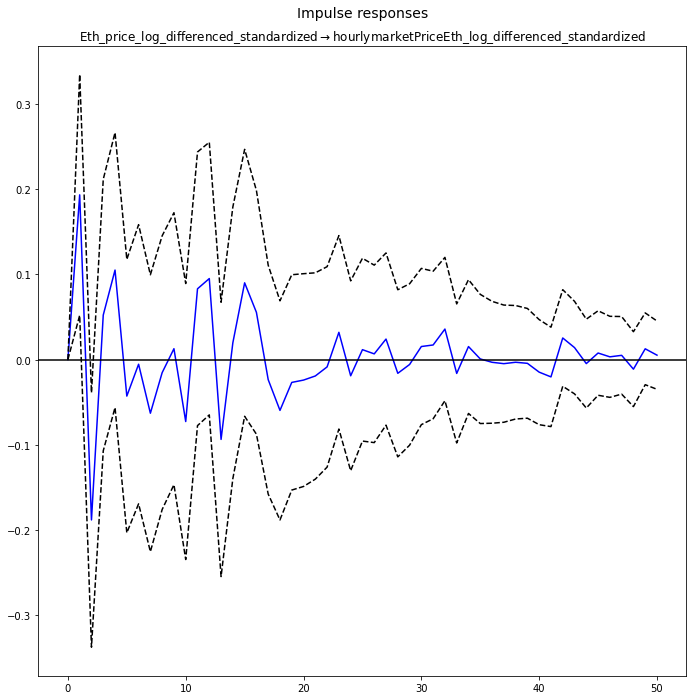

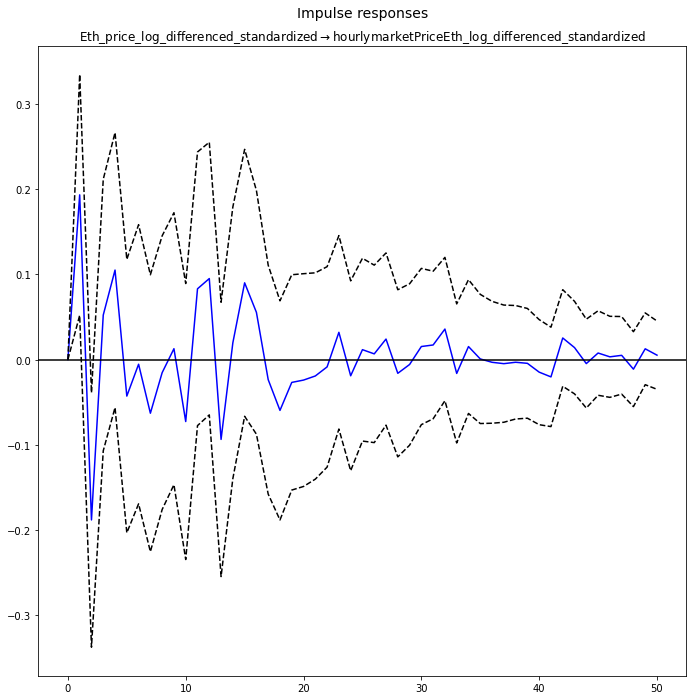

In [429]:
irf.plot(impulse='Eth_price_log_differenced_standardized', #variable providing the unit impulse
         response='hourlymarketPriceEth_log_differenced_standardized', # variable affected by the impulse
         plot_stderr = True, #Plot standard impulse response error bands
        repl=1000) #Number of replications for Monte Carlo and Sims-Zha standard errors

Standard errors are plotted by default at the 95% significance level.

## Correlation Analysis

,error_log_differenced_standardized,hourlyredemptionPriceActual_log_differenced_standardized,hourlymarketPriceEth_log_differenced_standardized,hourlymarketPriceUsd_log_differenced_standardized,Eth_price_log_differenced_standardized,15MinLaggedmarketPriceEth_log_differenced_standardized,totalCollateral_log_differenced_standardized,UniswapRAIBalanceRelativeToTotalSupply_log_differenced_standardized,MaxDebtCeiling_log_differenced_standardized,CollateralizationRatio_log_differenced_standardized
error_log_differenced_standardized,1.000000,-0.016492,0.047479,-0.803869,0.126927,-0.055357,0.119126,-0.215114,-0.275250,0.085231
hourlyredemptionPriceActual_log_differenced_standardized,-0.016492,1.000000,-0.166760,0.031899,0.158721,-0.087583,0.151806,-0.054138,0.284472,-0.177530
hourlymarketPriceEth_log_differenced_standardized,0.047479,-0.166760,1.000000,0.072808,-0.280983,0.217506,-0.133801,-0.260630,-0.208562,0.198644
hourlymarketPriceUsd_log_differenced_standardized,-0.803869,0.031899,0.072808,1.000000,-0.164402,0.115081,-0.066767,0.155987,0.244900,-0.161666
Eth_price_log_differenced_standardized,0.126927,0.158721,-0.280983,-0.164402,1.000000,-0.421309,0.145351,0.073905,0.170445,-0.023458
15MinLaggedmarketPriceEth_log_differenced_standardized,-0.055357,-0.087583,0.217506,0.115081,-0.421309,1.000000,-0.014658,-0.022358,0.039746,0.211036
totalCollateral_log_differenced_standardized,0.119126,0.151806,-0.133801,-0.066767,0.145351,-0.014658,1.000000,-0.218210,0.303824,-0.132848
UniswapRAIBalanceRelativeToTotalSupply_log_differenced_standardized,-0.215114,-0.054138,-0.260630,0.155987,0.073905,-0.022358,-0.218210,1.000000,0.045107,0.109501
MaxDebtCeiling_log_differenced_standardized,-0.275250,0.284472,-0.208562,0.244900,0.170445,0.039746,0.303824,0.045107,1.000000,-0.415648
CollateralizationRatio_log_differenced_standardized,0.085231,-0.177530,0.198644,-0.161666,-0.023458,0.211036,-0.132848,0.109501,-0.415648,1.000000


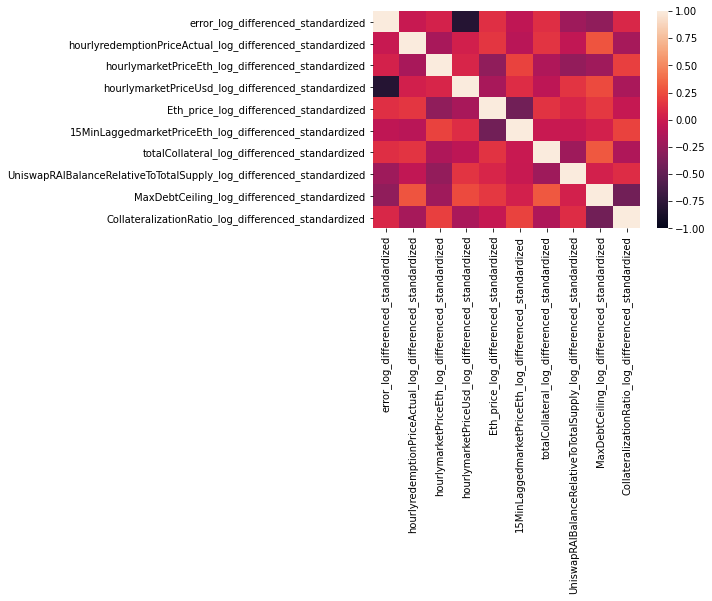

In [430]:
corr = P.corr()
corr_cols = corr.columns
ax = sns.heatmap(corr, vmax=1.0, vmin=-1.0);
corr

,error_log_differenced_standardized,hourlyredemptionPriceActual_log_differenced_standardized,hourlymarketPriceEth_log_differenced_standardized,hourlymarketPriceUsd_log_differenced_standardized,Eth_price_log_differenced_standardized,15MinLaggedmarketPriceEth_log_differenced_standardized,totalCollateral_log_differenced_standardized,UniswapRAIBalanceRelativeToTotalSupply_log_differenced_standardized,MaxDebtCeiling_log_differenced_standardized,CollateralizationRatio_log_differenced_standardized
error_log_differenced_standardized,1.000000,-0.038329,0.032985,-0.805599,0.117152,-0.052322,0.131656,-0.213419,-0.275825,0.081721
hourlyredemptionPriceActual_log_differenced_standardized,-0.038329,1.000000,-0.203070,0.048073,0.142316,-0.088895,0.145063,-0.043886,0.302683,-0.226928
hourlymarketPriceEth_log_differenced_standardized,0.032985,-0.203070,1.000000,0.090746,-0.296977,0.238633,-0.139807,-0.250303,-0.213425,0.203877
hourlymarketPriceUsd_log_differenced_standardized,-0.805599,0.048073,0.090746,1.000000,-0.167249,0.119536,-0.072011,0.150795,0.242402,-0.155100
Eth_price_log_differenced_standardized,0.117152,0.142316,-0.296977,-0.167249,1.000000,-0.416734,0.149954,0.076380,0.171297,-0.018931
15MinLaggedmarketPriceEth_log_differenced_standardized,-0.052322,-0.088895,0.238633,0.119536,-0.416734,1.000000,-0.020834,-0.019190,0.045786,0.199361
totalCollateral_log_differenced_standardized,0.131656,0.145063,-0.139807,-0.072011,0.149954,-0.020834,1.000000,-0.219688,0.307712,-0.162837
UniswapRAIBalanceRelativeToTotalSupply_log_differenced_standardized,-0.213419,-0.043886,-0.250303,0.150795,0.076380,-0.019190,-0.219688,1.000000,0.043684,0.121786
MaxDebtCeiling_log_differenced_standardized,-0.275825,0.302683,-0.213425,0.242402,0.171297,0.045786,0.307712,0.043684,1.000000,-0.417190
CollateralizationRatio_log_differenced_standardized,0.081721,-0.226928,0.203877,-0.155100,-0.018931,0.199361,-0.162837,0.121786,-0.417190,1.000000


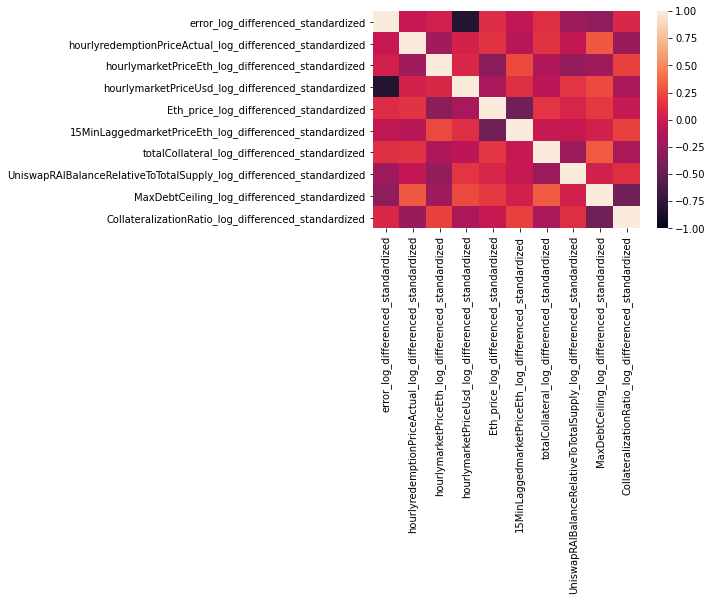

In [432]:
corr = P_interpolated.corr()
corr_cols = corr.columns
ax = sns.heatmap(corr, vmax=1.0, vmin=-1.0);
corr

### Validation of the relationship between the redemption rate to redemption price and error to redemption rate


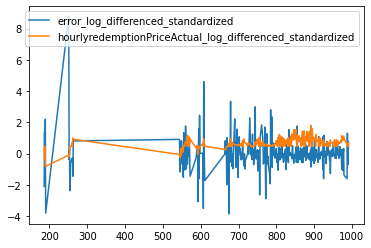

In [439]:
P[['error_log_differenced_standardized','hourlyredemptionPriceActual_log_differenced_standardized']].plot()

In [441]:
results.test_causality('hourlyredemptionPriceActual_log_differenced_standardized',
                       'error_log_differenced_standardized', kind='f',signif=0.05).summary()

Test statistic,Critical value,p-value,df
1.251,1.671,0.226,"(15, 1960)"


## Conclusion

Based on our VAR analysis without interpolation, validating our hypothesis, Eth price does have an influence on the Rai price. Because the timesteps differences are approximately normally distruted, we can assume that this analysis is correct. We can explore nonlinear interpolation or more intelligent resampling to make both results line up to improve our confidence of of the analysis.